# NEARCoder evaluation

NEARCoder, the Web3 Code LLM for the NEAR Protocol, is built on StarCoder2-3B. In this notebook, we are evaluating NEARCoder and its intermediary building steps in a structured testing protocol. Our primary hypothesis is that our final model doesn't lose performance to general coding tasks compared to the base model, while it increases its performance on specialized coding tasks related to the NEAR Protocol.

#### 1. Evaluation framework

We will evaluate the following four models:
- [StarCoder2-3B](https://huggingface.co/bigcode/starcoder2-3b): The base model.
- [NEAR-preTrainedStarCoder2](https://huggingface.co/jcarbonnell/NEAR-preTrainedStarCoder2): StarCoder2-3B pre-trained on NEAR-specific data.
- [NEAR-structTunedStarCoder2](https://huggingface.co/jcarbonnell/NEAR-structTunedStarcoder2): Structurally tuned version of the pre-trained model.
- [NEARCoder-3b](https://huggingface.co/jcarbonnell/NEARCoder-3b): The final model.

On the following four tasks:
- [HumanEvalPack](https://huggingface.co/datasets/bigcode/humanevalpack): an extension of OpenAI's general code challenges HumanEval with Javascript and Rust programming languages.
- NEAR Protocol Questions: Specific NEAR-related questions.
- dApp Trees Generation: Generating NEAR dApp structures with comments.
- Basic NEAR dApp Development: Building a simple NEAR dApp (e.g. an event calendar on the NEAR blockchain).

#### 2. Evaluation Metrics

Each task will have specific metrics to ensure a comprehensive evaluation:

- HumanEvalPack: BLEU score.
- NEAR Protocol Questions: BLEU, ROUGE-1.
- dApp Trees Generation: Structural similarity, comment quality.
- Basic NEAR dApp Development: Functionality, usability, and code quality.

#### 3. Comparative Analysis

After evaluating each model on each tasks, we will perform a comparative analysis to identify:

- Performance trends across models.
- Areas where the NEARCoder excels or needs improvement.
- Any trade-offs between general coding performance and NEAR-specific capabilities.

In [25]:
#!pip install datasets transformers evaluate rouge_score sentence-transformers

In [3]:
# import libraries
import os
import glob
import difflib
import re
import pandas as pd
import numpy as np
import torch
import random
import evaluate
import gc
import psutil
import json
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from datasets import load_dataset, concatenate_datasets
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from evaluate.visualization import radar_plot

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print ("Using MPS device:", device)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliencarbonnell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juliencarbonnell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Using MPS device: mps


## 1. Set up the evaluation environment

- Prepare the evaluation datasets
- Load the models

In [3]:
# Load general coding challenges for JavaScript (js) and Rust (rust)
js_dataset = load_dataset("bigcode/humanevalpack", "js", trust_remote_code=True)["test"]
rs_dataset = load_dataset("bigcode/humanevalpack", "rust", trust_remote_code=True)["test"]
# select first 5 rows
js_dataset = js_dataset[:5]
rs_dataset = rs_dataset[:5]
js_df = pd.DataFrame(js_dataset)
rs_df = pd.DataFrame(rs_dataset)
#concatenate them
human_eval_ds = pd.concat([js_df, rs_df], ignore_index=True)

# NEAR Protocol questions
near_protocol_questions = [
    "What is the Nightshade Sharding in NEAR Protocol?",
    "Explain the role of validators in the NEAR Protocol.",
    "How does NEAR handle transactions and smart contract execution?",
    "What are the advantages of NEAR's Proof of Stake consensus mechanism?",
    "Describe how NEAR's Rainbow Bridge works for cross-chain communication.",
    "What is the Aurora Engine on NEAR Protocol?"
]

# extract 2 examples of dApp trees from the original dataset
dapp_trees = load_dataset('jcarbonnell/NEARdAppsPrompts')['validation']
# Define a function to filter trees by length (number of lines and characters)
def filter_by_length(dataset, max_lines=20, max_chars=1000):
    filtered_entries = []
    for entry in dataset:
        tree = entry['tree']
        lines = tree.split('\n')
        if len(lines) <= max_lines and len(tree) <= max_chars:
            filtered_entries.append(entry)
    return filtered_entries

# Filter the dataset based on tree length
filtered_dapp_trees = filter_by_length(dapp_trees)

# If you need only a few examples, select the first N from filtered entries
N = 2
filtered_dapp_trees_limited = filtered_dapp_trees[:N]

# Transform the filtered entries into the desired format
transformed_dapp_trees = []
for entry in filtered_dapp_trees_limited:
    user_prompt = entry['user_prompt']
    tree = entry['tree']
    transformed_dapp_trees.append({
        "user_prompt": user_prompt,
        "tree": tree
    })

dapp_trees = transformed_dapp_trees

# Example of dApps
dapp_projects = [
    {
        "name": "NEAR Calendar App",
        "description": "A simple calendar dApp on NEAR for scheduling events.",
        "requirements": [
            "Users should be able to create, edit, and delete events.",
            "Events should be stored on the NEAR blockchain.",
            "Provide a user-friendly interface for managing events."
        ]
    },
    {
        "name": "NEAR Snake Game",
        "description": "A basic snake game dApp on NEAR.",
        "requirements": [
            "Implement a classic snake game.",
            "Store high scores on the NEAR blockchain.",
            "Provide an interface to view and reset high scores."
        ]
    }
]

# Define evaluation datasets
eval_datasets = {
    "HumanEval": human_eval_ds,
    "NEAR Protocol Questions": near_protocol_questions,
    "dApp Trees Generation": dapp_trees,
    "Basic NEAR dApp Development": dapp_projects
}

Index(['task_id', 'prompt', 'declaration', 'canonical_solution',
       'buggy_solution', 'bug_type', 'failure_symptoms', 'entry_point',
       'import', 'test_setup', 'test', 'example_test', 'signature',
       'docstring', 'instruction'],
      dtype='object')


In [4]:
# List of model names
model_names = {
    "StarCoder2-3B": "bigcode/starcoder2-3b",
    "NEAR-preTrainedStarCoder2": "jcarbonnell/NEAR-preTrainedStarCoder2",
    "NEAR-structTunedStarCoder2": "jcarbonnell/NEAR-structTunedStarCoder2",
    "NEARCoder-3b": "jcarbonnell/NEARCoder-3b"
}

# Dictionary to store tokenizers and models
models = {}
for model_name, model_path in model_names.items():
    print(f"Loading model and tokenizer for {model_name} from {model_path}")
    # load with memory optimization
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16)
    models[model_name] = {
        "tokenizer": tokenizer,
        "model": model
    }

print("All models and tokenizers loaded successfully.")

Loading model and tokenizer for StarCoder2-3B from bigcode/starcoder2-3b


/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading model and tokenizer for NEAR-preTrainedStarCoder2 from jcarbonnell/NEAR-preTrainedStarCoder2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading model and tokenizer for NEAR-structTunedStarCoder2 from jcarbonnell/NEAR-structTunedStarCoder2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading model and tokenizer for NEARCoder-3b from jcarbonnell/NEARCoder-3b


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All models and tokenizers loaded successfully.


## 2. Run evaluations

- Define evaluations for each task
- Execute evaluations across all models
- Collect and record results

#### General code challenges : Human Eval

In [ ]:
# normalize code for fair BLEU score
def normalize_code(code):
    # Remove comments, extra spaces, etc.
    code = re.sub(r'\s+', ' ', code)  # Collapse whitespace
    code = re.sub(r'//.*', '', code)  # Remove single line comments
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # Remove block comments
    code = code.strip()
    return code.replace('\n', ' ').strip()

# Define evaluation functions for HumanEval
def evaluate_human_eval(model, tokenizer, dataset):
    # Initialize the evaluation pipeline and BLEU scorer
    text_generation_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)
    bleu = evaluate.load('bleu')
    # List to store evaluation metrics
    evaluation_metrics = []
    
    # Iterate over each row in the DataFrame
    for index, challenge in dataset.iterrows():
        # Generate code from the prompt
        generated_code = text_generation_pipeline(
            challenge["prompt"],
            max_length=1024,
            num_return_sequences=1,
            truncation=False,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]
        
        # Normalize generated and reference code
        generated_code = normalize_code(generated_code)
        reference = normalize_code(challenge["canonical_solution"])
        
        # Compute the BLEU score
        bleu_score = bleu.compute(predictions=[generated_code], references=[[reference]])['bleu']
        # Append the BLEU score to the evaluation metrics list
        evaluation_metrics.append(bleu_score)
        
        # Print information about the challenge and BLEU score
        print(f"Challenge Prompt: {challenge['prompt']}")
        print(f"Generated Code: {generated_code}")
        print(f"Canonical Solution: {reference}")
        print(f"BLEU Score: {bleu_score:.2f}\n")

    return evaluation_metrics

# Define a function to save evaluation results
def save_evaluation_results(results, file_path):
    results.to_csv(file_path, index=False)

# Define the path to save/load evaluation results
human_eval_results_path = "human_eval_results.csv"

# Define a dictionary to store evaluation results
evaluation_results = {}

# Iterate over each model
for model_name, model_data in models.items():
    print(f"Evaluating model: {model_name}")
    model = model_data["model"]
    tokenizer = model_data["tokenizer"]

    # Evaluate the model on the HumanEval task
    evaluation_metrics = evaluate_human_eval(model, tokenizer, eval_datasets["HumanEval"])

    # Store the evaluation results in the dictionary
    evaluation_results[model_name] = evaluation_metrics

# Convert evaluation results to a DataFrame
all_results = []
for model_name, metrics in evaluation_results.items():
    for metric in metrics:
        #metric['model'] = model_name
        all_results.append(metric)

evaluation_df = pd.DataFrame(all_results)

# Save the evaluation results
save_evaluation_results(evaluation_df, human_eval_results_path)

# Print or export evaluation results
print(evaluation_df)

# Clear cache after saving results
del model, tokenizer, evaluation_df, evaluation_results, all_results
gc.collect()

# If using psutil to monitor memory usage
print(f"Memory usage after clearing: {psutil.virtual_memory().percent}%")

#### NEAR Protocol general knowledge:

In [11]:
reference_files_path = '/Users/juliencarbonnell/opencampus/nearDataPretraining'

# Load reference corpus function
def load_reference_corpus(file_path_pattern):
    reference_texts = []
    for file_path in glob.glob(file_path_pattern):
        with open(file_path, 'r', encoding='utf-8') as file:
            reference_texts.append(file.read())
    return reference_texts

# Load reference texts
reference_texts = load_reference_corpus(reference_files_path + "/*.txt")

# Print the number of references loaded
print(f"Loaded {len(reference_texts)} reference texts.")

Loaded 1136 reference texts.


In [6]:
# Initialize dictionaries to store predictions for each model
predictions_per_model = {model_name: [] for model_name in model_names}

# Generate predictions for each question for each model
for model_name, model_data in models.items():
    print(f"Generating predictions for model: {model_name}")
    tokenizer = model_data["tokenizer"]
    model = model_data["model"]
    
    # Initialize text generation pipeline for the current model
    text_generation_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    
    # Generate predictions for each question
    for question in near_protocol_questions:
        generated_answer = text_generation_pipeline(
            question,
            max_length=150,  # Set appropriate max length
            num_return_sequences=1,
            truncation=True,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]
        
        predictions_per_model[model_name].append(generated_answer.strip())
        
print(predictions_per_model)

{'StarCoder2-3B': ['What is the Nightshade Sharding in NEAR Protocol?\n\nThe Nightshade Sharding is a new sharding protocol that is designed to be compatible with the NEAR Protocol.\n\n## What is the Nightshade Sharding?\n\nThe Nightshade Sharding is a new sharding protocol that is designed to be compatible with the NEAR Protocol.\n\n## What is the Nightshade Sharding?\n\nThe Nightshade Sharding is a new sharding protocol that is designed to be compatible with the NEAR Protocol.\n\n## What is the Nightshade Sharding?\n\nThe Nightshade Sharding is a new sharding protocol that is designed to be compatible with the NEAR Protocol.\n\n## What is', 'Explain the role of validators in the NEAR Protocol.\n\nValidators are the nodes that participate in the consensus process. Validators are responsible for validating transactions and blocks. Validators are also responsible for maintaining the state of the blockchain. Validators are also responsible for maintaining the list of validators. Validato

In [25]:
# Load evaluation metrics
bleu = load("bleu", trust_remote_code=True)
rouge = load("rouge", trust_remote_code=True)

# Iterate over each model to compute BLEU and ROUGE scores
for model_name in predictions_per_model:
    print(f"Evaluating metrics for model: {model_name}")

    # Get predictions for the current model
    predictions = predictions_per_model[model_name]
    
    # Ensure each prediction has a corresponding reference(s)
    # For this example, we'll pair each prediction with all references for simplicity
    # You might need to change this depending on your evaluation strategy
    references_for_predictions = [reference_texts] * len(predictions)

    # Compute BLEU and ROUGE scores
    bleu_scores = []
    rouge_scores = []

    for i, prediction in enumerate(predictions):
        # Prepare single prediction for BLEU and ROUGE
        single_prediction = [prediction]

        # Prepare references for the single prediction
        # Here we assume each prediction is evaluated against all reference texts
        # Adjust this according to your specific needs
        single_references = [reference_texts]

        # Compute BLEU score using the internal tokenizer
        bleu_score = bleu.compute(predictions=single_prediction, references=single_references, tokenizer=word_tokenize)
        bleu_scores.append(bleu_score['bleu'])

        # Compute ROUGE score
        rouge_score = rouge.compute(predictions=single_prediction, references=single_references)

        # Append ROUGE-1 F1 score
        rouge_1_f1 = rouge_score['rouge1'] if 'rouge1' in rouge_score else 0
        rouge_scores.append(rouge_1_f1)
        
        # Print individual prediction scores
        print(f"Prediction {i + 1} BLEU Score: {bleu_score['bleu']:.2f}")
        print(f"Prediction {i + 1} ROUGE-1 Score: {rouge_1_f1:.2f}\n")

    # Print average BLEU and ROUGE scores for the current model
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_rouge_score = sum(rouge_scores) / len(rouge_scores) if rouge_scores else 0

    print(f"Average BLEU Score for {model_name}: {avg_bleu_score:.2f}")
    print(f"Average ROUGE-1 Score for {model_name}: {avg_rouge_score:.2f}")

# Optionally, save updated predictions_per_model back to the JSON file
with open('predictions_per_model.json', 'w') as f:
    json.dump(predictions_per_model, f)

Evaluating metrics for model: StarCoder2-3B
Prediction 1 BLEU Score: 0.51
Prediction 1 ROUGE-1 Score: 0.24

Prediction 2 BLEU Score: 0.33
Prediction 2 ROUGE-1 Score: 0.19

Prediction 3 BLEU Score: 0.55
Prediction 3 ROUGE-1 Score: 0.34

Prediction 4 BLEU Score: 0.55
Prediction 4 ROUGE-1 Score: 0.33

Prediction 5 BLEU Score: 0.54
Prediction 5 ROUGE-1 Score: 0.25

Prediction 6 BLEU Score: 0.70
Prediction 6 ROUGE-1 Score: 0.30

Average BLEU Score for StarCoder2-3B: 0.53
Average ROUGE-1 Score for StarCoder2-3B: 0.28
Evaluating metrics for model: NEAR-preTrainedStarCoder2
Prediction 1 BLEU Score: 0.37
Prediction 1 ROUGE-1 Score: 0.22

Prediction 2 BLEU Score: 0.54
Prediction 2 ROUGE-1 Score: 0.27

Prediction 3 BLEU Score: 0.60
Prediction 3 ROUGE-1 Score: 0.38

Prediction 4 BLEU Score: 0.44
Prediction 4 ROUGE-1 Score: 0.29

Prediction 5 BLEU Score: 0.59
Prediction 5 ROUGE-1 Score: 0.32

Prediction 6 BLEU Score: 0.57
Prediction 6 ROUGE-1 Score: 0.28

Average BLEU Score for NEAR-preTrainedStarC

#### NEAR dApp structure generation:

In [30]:
# Define evaluation functions for dApp tree generation
def calculate_structural_similarity(generated_tree, reference_tree):
    generated_lines = generated_tree.split('\n')
    reference_lines = reference_tree.split('\n')
    similarity = difflib.SequenceMatcher(None, generated_lines, reference_lines).ratio()
    return similarity

def evaluate_comment_quality(generated_tree, reference_tree):
    generated_comments = [line for line in generated_tree.split('\n') if line.strip().startswith('#')]
    reference_comments = [line for line in reference_tree.split('\n') if line.strip().startswith('#')]
    similarity = difflib.SequenceMatcher(None, generated_comments, reference_comments).ratio()
    return similarity

def evaluate_dapp_trees_generation(model, tokenizer, dataset):
    text_generation_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)
    evaluation_metrics = {
        "user_prompt": [],
        "generated_tree": [],
        "structural_similarity": [],
        "comment_quality": []
    }

    for tree_example in dataset:
        generated_tree = text_generation_pipeline(
            tree_example["user_prompt"], 
            max_length=1024, 
            num_return_sequences=1,
            truncation=True,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]

        reference_tree = tree_example["tree"]
        structural_similarity = calculate_structural_similarity(generated_tree, reference_tree)
        comment_quality = evaluate_comment_quality(generated_tree, reference_tree)

        # Collect evaluation metrics
        evaluation_metrics["user_prompt"].append(tree_example["user_prompt"])
        evaluation_metrics["generated_tree"].append(generated_tree)
        evaluation_metrics["structural_similarity"].append(structural_similarity)
        evaluation_metrics["comment_quality"].append(comment_quality)

        # Print evaluation metrics for the current example
        #print(f"User Prompt: {tree_example['user_prompt']}")
        #print(f"Generated Tree:\n{generated_tree}")
        #print(f"Reference Tree:\n{reference_tree}")
        print(f"Structural Similarity: {structural_similarity:.2f}")
        print(f"Comment Quality: {comment_quality:.2f}\n")

    return evaluation_metrics

# Evaluate each preloaded model on dApp trees generation
for model_name in model_names.keys():
    print(f"Evaluating model: {model_name}")
    model = models[model_name]["model"]
    tokenizer = models[model_name]["tokenizer"]
    evaluation_metrics = evaluate_dapp_trees_generation(model, tokenizer, dapp_trees)
    print(f"Evaluation Metrics for {model_name}:\n", evaluation_metrics)

Evaluating model: StarCoder2-3B
Structural Similarity: 0.03
Comment Quality: 0.00

Structural Similarity: 0.02
Comment Quality: 0.00

Evaluation Metrics for StarCoder2-3B:
 {'user_prompt': ['Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be built using Vue.js.\n2. Include necessary files typically required for a Vue.js project such as configuration files, build scripts, and main application files.\n3. Incorporate all relevant dependencies and packages needed for a Vue.js project.\n4. Ensure the project includes npm setup for installing dependencies and scripts for serving, building, and analyzing the production bundle.\n5. Adhere to common Vue.js project structure conventions while setting up the project.\n\nProvide a well-organized directory structure and file list based on these requirements.', 'Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be based on a Rust Smart Con

Structural Similarity: 0.03
Comment Quality: 0.00

Structural Similarity: 0.03
Comment Quality: 0.00

Evaluation Metrics for NEAR-preTrainedStarCoder2:
 {'user_prompt': ['Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be built using Vue.js.\n2. Include necessary files typically required for a Vue.js project such as configuration files, build scripts, and main application files.\n3. Incorporate all relevant dependencies and packages needed for a Vue.js project.\n4. Ensure the project includes npm setup for installing dependencies and scripts for serving, building, and analyzing the production bundle.\n5. Adhere to common Vue.js project structure conventions while setting up the project.\n\nProvide a well-organized directory structure and file list based on these requirements.', 'Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be based on a Rust Smart Contract template.\n2. 

Structural Similarity: 0.03
Comment Quality: 1.00

Structural Similarity: 0.03
Comment Quality: 1.00

Evaluation Metrics for NEAR-structTunedStarCoder2:
 {'user_prompt': ['Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be built using Vue.js.\n2. Include necessary files typically required for a Vue.js project such as configuration files, build scripts, and main application files.\n3. Incorporate all relevant dependencies and packages needed for a Vue.js project.\n4. Ensure the project includes npm setup for installing dependencies and scripts for serving, building, and analyzing the production bundle.\n5. Adhere to common Vue.js project structure conventions while setting up the project.\n\nProvide a well-organized directory structure and file list based on these requirements.', 'Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be based on a Rust Smart Contract template.\n2.

Structural Similarity: 0.02
Comment Quality: 0.00

Structural Similarity: 0.03
Comment Quality: 1.00

Evaluation Metrics for NEARCoder-3b:
 {'user_prompt': ['Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be built using Vue.js.\n2. Include necessary files typically required for a Vue.js project such as configuration files, build scripts, and main application files.\n3. Incorporate all relevant dependencies and packages needed for a Vue.js project.\n4. Ensure the project includes npm setup for installing dependencies and scripts for serving, building, and analyzing the production bundle.\n5. Adhere to common Vue.js project structure conventions while setting up the project.\n\nProvide a well-organized directory structure and file list based on these requirements.', 'Create a project structure for a NEAR DApp based on the following requirements:\n\n1. The project should be based on a Rust Smart Contract template.\n2. Include a `Ca

#### Basic NEAR dApp development:

In [33]:
# Evaluation functions for NEAR dApp generation
def evaluate_functionality(generated_code, requirements):
    functionality_score = sum(1 for requirement in requirements if all(keyword.lower() in generated_code.lower() for keyword in requirement.split()))
    return functionality_score / len(requirements) if requirements else 0

def evaluate_usability(generated_code):
    ui_elements = ['button', 'input', 'form', 'interface', 'user', 'display']
    usability_score = sum(1 for element in ui_elements if element.lower() in generated_code.lower())
    return usability_score / len(ui_elements)

def evaluate_code_quality(generated_code):
    quality_indicators = ['def ', 'function ', 'class ', '#', 'import ', 'contract ']
    code_quality_score = sum(1 for indicator in quality_indicators if indicator.lower() in generated_code.lower())
    total_lines = len(generated_code.split('\n'))
    indented_lines = len([line for line in generated_code.split('\n') if re.match(r'^\s+', line)])
    indentation_score = indented_lines / total_lines if total_lines > 0 else 0
    return (code_quality_score / len(quality_indicators) + indentation_score) / 2

def evaluate_basic_near_dapp_development(model, tokenizer, dataset):
    text_generation_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)
    evaluation_metrics = {
        "name": [],
        "description": [],
        "generated_code": [],
        "functionality": [],
        "usability": [],
        "code_quality": []
    }

    for project in dataset:
        generated_code = text_generation_pipeline(
            project["description"], 
            max_length=1024, 
            num_return_sequences=1,
            truncation=True,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]
        
        functionality_score = evaluate_functionality(generated_code, project["requirements"])
        usability_score = evaluate_usability(generated_code)
        code_quality_score = evaluate_code_quality(generated_code)

        # Collect evaluation metrics
        evaluation_metrics["name"].append(project["name"])
        evaluation_metrics["description"].append(project["description"])
        evaluation_metrics["generated_code"].append(generated_code)
        evaluation_metrics["functionality"].append(functionality_score)
        evaluation_metrics["usability"].append(usability_score)
        evaluation_metrics["code_quality"].append(code_quality_score)

        # Print evaluation metrics for the current project
        print(f"Project Name: {project['name']}")
        print(f"Project Description: {project['description']}")
        print(f"Generated Code:\n{generated_code}")
        print(f"Functionality Score: {functionality_score:.2f}")
        print(f"Usability Score: {usability_score:.2f}")
        print(f"Code Quality Score: {code_quality_score:.2f}\n")

    return evaluation_metrics

# Evaluate each preloaded model on dApp generation
for model_name in model_names.keys():
    print(f"Evaluating model: {model_name}")
    model = models[model_name]["model"]
    tokenizer = models[model_name]["tokenizer"]
    evaluation_metrics = evaluate_basic_near_dapp_development(model, tokenizer, dapp_projects)
    print(f"Evaluation Metrics for {model_name}:\n", evaluation_metrics)

Evaluating model: StarCoder2-3B
Project Name: NEAR Calendar App
Project Description: A simple calendar dApp on NEAR for scheduling events.
Generated Code:
A simple calendar dApp on NEAR for scheduling events.

## How to run

### Install NEAR CLI

```
npm install -g near-cli
```

### Create a new account

```
near create-account <account-id>
```

### Deploy the contract

```
near deploy --wasm <path-to-wasm-file> --accountId <account-id>
```

### Run the contract

```
near call <account-id> <contract-id> <method-name> --accountId <account-id> --amount 0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Project Name: NEAR Calendar App
Project Description: A simple calendar dApp on NEAR for scheduling events.
Generated Code:
A simple calendar dApp on NEAR for scheduling events.

## Getting started

### Prerequisites

- [Node.js](https://nodejs.org/en/)
- [Yarn](https://yarnpkg.com/)
- [Git](https://git-scm.com/)
- [NEAR CLI](https://docs.near.org/tools/near-cli)

### Installation

```bash
git clone https://github.com/near-examples/calendar-dapp.git
cd calendar-dapp
yarn install
```

### Configuration

Create a `.env` file in the root directory of the project.

```bash
touch.env
```

Add the following environment variables to the `.env` file.

```bash
# NEAR account ID
ACCOUNT_ID=your-account-id.testnet

# NEAR account private key
PRIVATE_KEY=your-account-private-key

# NEAR network ID
NETWORK_ID=testnet
```

### Running the app

```bash
yarn start
```

## Contributing

We welcome community contributions to this project. Please see our [Contributing Guidelines](https://github.com/near-e

Project Name: NEAR Calendar App
Project Description: A simple calendar dApp on NEAR for scheduling events.
Generated Code:
A simple calendar dApp on NEAR for scheduling events.

## Getting started

```bash
git clone https://github.com/near-examples/calendar-frontend.git
cd calendar-frontend
yarn install
yarn start
```

## Deploying

```bash
yarn deploy
```

## License

[MIT](LICENSE)

Functionality Score: 0.00
Usability Score: 0.00
Code Quality Score: 0.08

Project Name: NEAR Snake Game
Project Description: A basic snake game dApp on NEAR.
Generated Code:
A basic snake game dApp on NEAR.

## Getting Started

### Prerequisites

- [Node.js](https://nodejs.org/en/)
- [yarn](https://yarnpkg.com/)
- [near-cli](https://github.com/near/near-cli)

### Installation

```bash
git clone https://github.com/near-examples/snake-game-js
cd snake-game-js
yarn
```

### Compile

```bash
yarn build
```

### Deploy

```bash
near deploy
```

### Run

```bash
yarn start
```

### Test

```bash
yarn test
```



In [34]:
data = [
    ['StarCoder2-3b', 
     np.mean([0.07, 0.04, 0.00, 0.43, 0.05, 0.03, 0.03, 0.00, 0.05, 0.06]), 
     '0.53',
     '0.28',
     np.mean([0.028, 0.020]),
     np.mean([0.0, 0.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.0, 0.16]),
     np.mean([0.083, 0.083])
    ], 
    ['NEAR-preTrainedStarCoder2', 
     np.mean([0.00, 0.04, 0.00, 0.30, 0.13, 0.07, 0.14, 0.00, 0.04, 0.08]), 
     '0.52',
     '0.29',
     np.mean([0.028, 0.027]),
     np.mean([0.0, 0.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.16, 0.0]),
     np.mean([0.083, 0.083])
    ], 
    ['NEAR-structTunedStarCoder2', 
     np.mean([0.05, 0.09, 0.00, 0.29, 0.04, 0.04, 0.07, 0.00, 0.02, 0.09]), 
     '0.54',
     '0.26',
     np.mean([0.033, 0.025]),
     np.mean([1.0, 1.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.083, 0.083])
    ], 
    ['NEARCoder-3b', 
     np.mean([0.00, 0.00, 0.00, 0.13, 0.11, 0.07, 0.00, 0.00, 0.13, 0.31]), 
     '0.49',
     '0.27',
     np.mean([0.020, 0.029]),
     np.mean([0.0, 1.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.0, 0.0]),
     np.mean([0.16, 0.083])
    ]
]

df = pd.DataFrame(data, columns=['model',
                                 'humanEval_bleu',
                                 'nearQuestions_bleu',
                                 'nearQuestions_rouge1',
                                 'dAppTrees_structure',
                                 'dAppTrees_comment',
                                 'dAppGen_functionality',
                                 'dAppGen_usability',
                                 'dAppGen_quality',
                                ])
print(df)

# Save DataFrame to CSV file
csv_filename = "NEARCoderEval_metrics.csv"
df.to_csv(csv_filename, index=False)

                        model  humanEval_bleu nearQuestions_bleu  \
0               StarCoder2-3b           0.076               0.53   
1   NEAR-preTrainedStarCoder2           0.080               0.52   
2  NEAR-structTunedStarCoder2           0.069               0.54   
3                NEARCoder-3b           0.075               0.49   

  nearQuestions_rouge1  dAppTrees_structure  dAppTrees_comment  \
0                 0.28               0.0240                0.0   
1                 0.29               0.0275                0.0   
2                 0.26               0.0290                1.0   
3                 0.27               0.0245                0.5   

   dAppGen_functionality  dAppGen_usability  dAppGen_quality  
0                    0.0               0.08           0.0830  
1                    0.0               0.08           0.0830  
2                    0.0               0.00           0.0830  
3                    0.0               0.00           0.1215  


### 3. Compare evaluation results

- Look where NEARCoder performs better or worst than StarCoder, or where the finetuning doesn't change performance.
- Use graphs to visualize the results.

In [2]:
NEARCoderEval = pd.read_csv("NEARCoderEval_metrics.csv")
print(NEARCoderEval)

                        model  humanEval_bleu  nearQuestions_bleu  \
0               StarCoder2-3b           0.076                0.53   
1   NEAR-preTrainedStarCoder2           0.080                0.52   
2  NEAR-structTunedStarCoder2           0.069                0.54   
3                NEARCoder-3b           0.075                0.49   

   nearQuestions_rouge1  dAppTrees_structure  dAppTrees_comment  \
0                  0.28               0.0240                0.0   
1                  0.29               0.0275                0.0   
2                  0.26               0.0290                1.0   
3                  0.27               0.0245                0.5   

   dAppGen_functionality  dAppGen_usability  dAppGen_quality  
0                    0.0               0.08           0.0830  
1                    0.0               0.08           0.0830  
2                    0.0               0.00           0.0830  
3                    0.0               0.00           0.1215  


/opt/anaconda3/lib/python3.11/site-packages/evaluate/visualization.py:47: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*ranges[j])
/opt/anaconda3/lib/python3.11/site-packages/evaluate/visualization.py:56: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*ranges[j])
/opt/anaconda3/lib/python3.11/site-packages/evaluate/visualization.py:124: RuntimeWarning: invalid value encountered in scalar divide
  sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
/var/folders/92/7zcym99s7h54kvkc6wxlmn5w0000gn/T/ipykernel_75559/1229957070.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


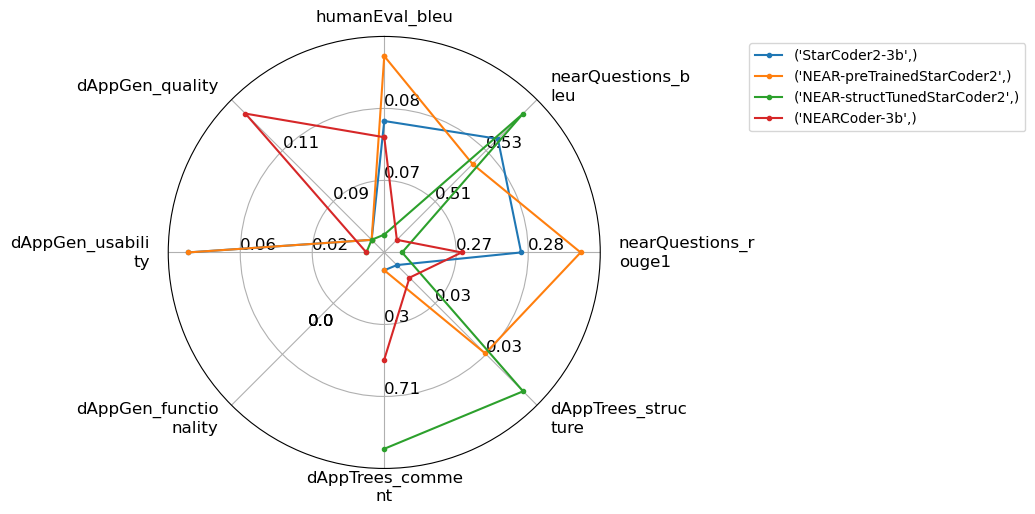

In [6]:
# visualize models' performance on a graph
metrics = [
    'humanEval_bleu', 
    'nearQuestions_bleu', 
    'nearQuestions_rouge1', 
    'dAppTrees_structure', 
    'dAppTrees_comment', 
    'dAppGen_functionality', 
    'dAppGen_usability', 
    'dAppGen_quality'
]

# Convert DataFrame to a list of dictionaries
data_for_plot = []
for index, row in NEARCoderEval.iterrows():
    entry = {metric: row[metric] for metric in metrics}
    data_for_plot.append(entry)

# Create radar plot using evaluate
plot = radar_plot(data=data_for_plot, model_names=NEARCoderEval['model'])
plot.show()

In [ ]:
# which model performs best on which task?
